# Enhancing Image Reconstruction with Prediction model using DCGAN

### Experiment 3: Pokemon Dataset

The final experiment is performed on the dataset which includes images of 809 unique Pokémon. Yes, the Pokémon universe has really expanded a lot! Jokes aside, the decision of selecting the dataset is hugely because of the diversity of Images.

All images are inimitable with different features, including shape, size, color, etc. leading to further increase the complexity of this experiment. So, there no relation to contextual and perceptual information within images.

In [1]:
# Loading required packages
import os
import cv2
import glob
import torch
import random
import imageio
import torch.nn as nn
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import torchvision.utils as vutils
from torch.autograd import Variable
import torchvision.datasets as dsets
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import mpmath
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import splitfolders as sf
from numpy import asarray, expand_dims, log, mean, exp
from image_utils import get_tensor_image, save_tensor_images

In [5]:
# Creating a Cuda Environment
cudnn.benchmark = True

# Set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  6062


# Training DCGAN

In [6]:
# Initializing Hyperparameters for the model.
image_size = 64
nz = 100
nc = 3
D_output_dim = 1
ngf = 128
ndf = 128
ngpu = 1

learning_rate = 0.0002
betas = (0.5, 0.999)
batch_size = 128
num_epochs = 500
data_dir = './data/Pokemon/images/'
def save_checkpoint(state, filename="./data/Pokemon/checkpoints/Pokemon_checkpoint.pth.tar"):
    print("=> Saving Checkpoint")
    torch.save(state, filename)

In [7]:
# Split with a 80-20 ratio.
sf.ratio(data_dir, output="./data/Pokemon/output", seed=manualSeed, ratio=(.8, .2), group_prefix=None)

Copying files: 809 files [00:00, 870.35 files/s]


In [8]:
# Performing transformation and loading the dataset.
train_dir = './data/Pokemon/output/train/'
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

pokemon_data = dsets.ImageFolder(train_dir, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=pokemon_data,
                                          batch_size=batch_size,
                                          shuffle=True)

# Checking the availability of cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device, " will be used.\n")

cuda  will be used.



## Generator Network

The Generator network is a neual network that takes a noise vector as an input and generates an image after passing through several hidden layers.

The DCGAN generator has Transpose Convolution layers and includes batch normalization instead of pooling payers.

The output of the network is a Tanh Function providing input to the Discriminator network.

In [9]:
#The Generator Neural Network Model
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
            return output

NetG = Generator(ngpu).to(device)
print(NetG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


## Discriminator Network

The Discriminator network is a neual network that takes real dataset images as an input and it passes through several hidden layers.

The DCGAN generator has Convolution layers and includes batch normalization instead of pooling payers.

It also uses LeakyReLU Activation function and the output of the network is a Sigmoid Function acting as a classifier network.

In [10]:
#The Discriminator Neural Network Model
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

NetD = Discriminator(ngpu).to(device)
print(NetD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
# Initializing the Loss function.
criterion = torch.nn.BCELoss()

#Creating Noise input for the Generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Initializing Network Optimizers
G_optimizer = torch.optim.Adam(NetG.parameters(), lr=learning_rate, betas=betas)
D_optimizer = torch.optim.Adam(NetD.parameters(), lr=learning_rate, betas=betas)

G_losses = []
D_losses = []
img_list = []
iters = 0

In [39]:
# Training the DCGAN model

print("Starting Training Loop...")
for epoch in range(num_epochs):
    
    if epoch % 5 == 0:
        checkpoint = {'state_dict1' : NetD.state_dict(), 
                      'optimizer1': D_optimizer.state_dict(),
                     'state_dict2' : NetG.state_dict(), 
                      'optimizer2': G_optimizer.state_dict()}
        save_checkpoint(checkpoint)
    
    for i, (images,targets) in enumerate(data_loader, 0):
        
        # 1st Step: Updating the weights of the neural network of the discriminator

        NetD.zero_grad()
        
        # Training the discriminator with a real image of the dataset
        real = images.to(device)
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0])*0.9).to(device)
        output = NetD(input)
        errD_real = criterion(output, target)
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1)).to(device)
        fake = NetG(noise)
        target = Variable(torch.zeros(input.size()[0])*0.1).to(device)
        output = NetD(fake.detach())
        errD_fake = criterion(output, target)
        
        # Backpropagating the total error
        errD = errD_real + errD_fake
        errD.backward()
        D_optimizer.step()

        # 2nd Step: Updating the weights of the neural network of the generator

        NetG.zero_grad()
        target = Variable(torch.ones(input.size()[0])).to(device)
        output = NetD(fake)
        errG = criterion(output, target)
        errG.backward()
        G_optimizer.step()
        
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, num_epochs, i, len(data_loader), errD.data, errG.data))
        
        # loss values
        D_losses.append(errD.item())
        G_losses.append(errG.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = NetG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
        if i % 100 == 0:
            vutils.save_image(real, '%s/real_samples.png' % "./data/Pokemon/training_results", normalize = True)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./data/Pokemon/training_results", epoch), normalize = True)

Starting Training Loop...
=> Saving Checkpoint
[0/500][0/6] Loss_D: 1.2026 Loss_G: 1.2113
[0/500][1/6] Loss_D: 0.9845 Loss_G: 2.2430
[0/500][2/6] Loss_D: 0.9783 Loss_G: 1.6028
[0/500][3/6] Loss_D: 0.8282 Loss_G: 1.8926
[0/500][4/6] Loss_D: 0.7881 Loss_G: 2.3295
[0/500][5/6] Loss_D: 0.7665 Loss_G: 2.0967
[1/500][0/6] Loss_D: 0.8779 Loss_G: 2.2513
[1/500][1/6] Loss_D: 0.9449 Loss_G: 1.9287
[1/500][2/6] Loss_D: 0.8164 Loss_G: 2.2652
[1/500][3/6] Loss_D: 0.7792 Loss_G: 1.5267
[1/500][4/6] Loss_D: 0.8845 Loss_G: 3.7241
[1/500][5/6] Loss_D: 1.3765 Loss_G: 1.0591
[2/500][0/6] Loss_D: 1.8170 Loss_G: 2.6250
[2/500][1/6] Loss_D: 1.3020 Loss_G: 1.8470
[2/500][2/6] Loss_D: 0.9634 Loss_G: 1.0222
[2/500][3/6] Loss_D: 0.9987 Loss_G: 1.6393
[2/500][4/6] Loss_D: 1.0170 Loss_G: 2.1482
[2/500][5/6] Loss_D: 0.9062 Loss_G: 2.0729
[3/500][0/6] Loss_D: 1.0143 Loss_G: 1.4621
[3/500][1/6] Loss_D: 0.9347 Loss_G: 1.9335
[3/500][2/6] Loss_D: 0.9769 Loss_G: 1.7478
[3/500][3/6] Loss_D: 0.8130 Loss_G: 1.9825
[3/500]

[30/500][4/6] Loss_D: 0.8570 Loss_G: 2.7798
[30/500][5/6] Loss_D: 0.8913 Loss_G: 1.3695
[31/500][0/6] Loss_D: 0.8747 Loss_G: 3.0761
[31/500][1/6] Loss_D: 0.8009 Loss_G: 2.3323
[31/500][2/6] Loss_D: 0.8906 Loss_G: 1.4294
[31/500][3/6] Loss_D: 0.8347 Loss_G: 3.1938
[31/500][4/6] Loss_D: 0.9033 Loss_G: 1.7484
[31/500][5/6] Loss_D: 0.4399 Loss_G: 3.0808
[32/500][0/6] Loss_D: 1.0941 Loss_G: 3.5296
[32/500][1/6] Loss_D: 1.3585 Loss_G: 2.2093
[32/500][2/6] Loss_D: 0.8935 Loss_G: 2.1172
[32/500][3/6] Loss_D: 0.7526 Loss_G: 2.5002
[32/500][4/6] Loss_D: 0.7706 Loss_G: 2.8034
[32/500][5/6] Loss_D: 0.8922 Loss_G: 1.3378
[33/500][0/6] Loss_D: 0.9864 Loss_G: 5.5731
[33/500][1/6] Loss_D: 2.7115 Loss_G: 0.8837
[33/500][2/6] Loss_D: 1.3047 Loss_G: 2.2404
[33/500][3/6] Loss_D: 1.1076 Loss_G: 2.2347
[33/500][4/6] Loss_D: 1.0233 Loss_G: 1.9640
[33/500][5/6] Loss_D: 0.7945 Loss_G: 1.9338
[34/500][0/6] Loss_D: 1.0065 Loss_G: 2.2853
[34/500][1/6] Loss_D: 0.9396 Loss_G: 1.9538
[34/500][2/6] Loss_D: 1.1756 Los

[61/500][2/6] Loss_D: 1.0459 Loss_G: 1.2295
[61/500][3/6] Loss_D: 1.0255 Loss_G: 1.7409
[61/500][4/6] Loss_D: 0.9483 Loss_G: 1.6246
[61/500][5/6] Loss_D: 0.7853 Loss_G: 2.5876
[62/500][0/6] Loss_D: 1.0084 Loss_G: 1.4632
[62/500][1/6] Loss_D: 0.8463 Loss_G: 1.7914
[62/500][2/6] Loss_D: 0.8556 Loss_G: 2.0928
[62/500][3/6] Loss_D: 0.7226 Loss_G: 2.1359
[62/500][4/6] Loss_D: 0.7198 Loss_G: 2.1906
[62/500][5/6] Loss_D: 0.8470 Loss_G: 5.1409
[63/500][0/6] Loss_D: 0.8614 Loss_G: 1.9973
[63/500][1/6] Loss_D: 0.9662 Loss_G: 2.4397
[63/500][2/6] Loss_D: 0.9789 Loss_G: 1.7874
[63/500][3/6] Loss_D: 0.7957 Loss_G: 2.1423
[63/500][4/6] Loss_D: 0.8517 Loss_G: 2.4412
[63/500][5/6] Loss_D: 0.7525 Loss_G: 2.7227
[64/500][0/6] Loss_D: 0.7645 Loss_G: 2.2697
[64/500][1/6] Loss_D: 0.6334 Loss_G: 2.3276
[64/500][2/6] Loss_D: 0.8861 Loss_G: 2.7183
[64/500][3/6] Loss_D: 0.7486 Loss_G: 2.1697
[64/500][4/6] Loss_D: 0.8559 Loss_G: 2.4159
[64/500][5/6] Loss_D: 0.5365 Loss_G: 4.1593
=> Saving Checkpoint
[65/500][0/

[92/500][0/6] Loss_D: 1.5802 Loss_G: 3.1081
[92/500][1/6] Loss_D: 1.4479 Loss_G: 1.9506
[92/500][2/6] Loss_D: 1.0417 Loss_G: 1.4713
[92/500][3/6] Loss_D: 1.0563 Loss_G: 1.8745
[92/500][4/6] Loss_D: 1.1022 Loss_G: 1.5298
[92/500][5/6] Loss_D: 1.3698 Loss_G: 3.2702
[93/500][0/6] Loss_D: 1.6065 Loss_G: 1.6757
[93/500][1/6] Loss_D: 0.7598 Loss_G: 1.2372
[93/500][2/6] Loss_D: 0.7995 Loss_G: 2.2679
[93/500][3/6] Loss_D: 0.8555 Loss_G: 2.5876
[93/500][4/6] Loss_D: 1.1052 Loss_G: 1.5786
[93/500][5/6] Loss_D: 0.9731 Loss_G: 2.2433
[94/500][0/6] Loss_D: 1.6065 Loss_G: 2.4246
[94/500][1/6] Loss_D: 1.0624 Loss_G: 2.5267
[94/500][2/6] Loss_D: 0.7742 Loss_G: 1.5929
[94/500][3/6] Loss_D: 0.7726 Loss_G: 1.9108
[94/500][4/6] Loss_D: 0.9873 Loss_G: 2.3240
[94/500][5/6] Loss_D: 0.8218 Loss_G: 2.6522
=> Saving Checkpoint
[95/500][0/6] Loss_D: 1.0802 Loss_G: 1.4076
[95/500][1/6] Loss_D: 0.8540 Loss_G: 2.6903
[95/500][2/6] Loss_D: 0.9865 Loss_G: 2.0859
[95/500][3/6] Loss_D: 0.9205 Loss_G: 1.8033
[95/500][4/

[122/500][1/6] Loss_D: 0.9734 Loss_G: 2.4112
[122/500][2/6] Loss_D: 0.7966 Loss_G: 1.9694
[122/500][3/6] Loss_D: 0.8704 Loss_G: 1.8203
[122/500][4/6] Loss_D: 0.7824 Loss_G: 2.0110
[122/500][5/6] Loss_D: 0.5806 Loss_G: 3.5310
[123/500][0/6] Loss_D: 1.0492 Loss_G: 2.9818
[123/500][1/6] Loss_D: 1.0850 Loss_G: 1.6103
[123/500][2/6] Loss_D: 0.7920 Loss_G: 1.8534
[123/500][3/6] Loss_D: 0.8324 Loss_G: 2.6907
[123/500][4/6] Loss_D: 0.9800 Loss_G: 2.3265
[123/500][5/6] Loss_D: 1.1788 Loss_G: 4.8404
[124/500][0/6] Loss_D: 2.4192 Loss_G: 1.4275
[124/500][1/6] Loss_D: 0.8283 Loss_G: 1.7037
[124/500][2/6] Loss_D: 1.0648 Loss_G: 2.8936
[124/500][3/6] Loss_D: 1.3148 Loss_G: 1.5730
[124/500][4/6] Loss_D: 1.1042 Loss_G: 2.3823
[124/500][5/6] Loss_D: 2.2539 Loss_G: 2.7099
=> Saving Checkpoint
[125/500][0/6] Loss_D: 1.8831 Loss_G: 2.5297
[125/500][1/6] Loss_D: 1.4318 Loss_G: 1.1947
[125/500][2/6] Loss_D: 0.9771 Loss_G: 2.1727
[125/500][3/6] Loss_D: 1.1845 Loss_G: 1.8906
[125/500][4/6] Loss_D: 0.8030 Loss

[152/500][1/6] Loss_D: 0.6983 Loss_G: 2.0279
[152/500][2/6] Loss_D: 0.7926 Loss_G: 2.0928
[152/500][3/6] Loss_D: 0.7005 Loss_G: 2.3094
[152/500][4/6] Loss_D: 0.6590 Loss_G: 2.4681
[152/500][5/6] Loss_D: 0.4744 Loss_G: 3.0198
[153/500][0/6] Loss_D: 0.6813 Loss_G: 2.0980
[153/500][1/6] Loss_D: 0.7144 Loss_G: 2.5884
[153/500][2/6] Loss_D: 0.7769 Loss_G: 1.9990
[153/500][3/6] Loss_D: 0.9875 Loss_G: 2.7444
[153/500][4/6] Loss_D: 1.0812 Loss_G: 2.3371
[153/500][5/6] Loss_D: 0.5560 Loss_G: 2.7598
[154/500][0/6] Loss_D: 1.5746 Loss_G: 3.2917
[154/500][1/6] Loss_D: 0.5753 Loss_G: 3.7635
[154/500][2/6] Loss_D: 1.1651 Loss_G: 2.1022
[154/500][3/6] Loss_D: 0.9386 Loss_G: 2.3748
[154/500][4/6] Loss_D: 1.0364 Loss_G: 2.2167
[154/500][5/6] Loss_D: 0.8373 Loss_G: 3.8092
=> Saving Checkpoint
[155/500][0/6] Loss_D: 0.6700 Loss_G: 1.5630
[155/500][1/6] Loss_D: 0.6916 Loss_G: 2.3861
[155/500][2/6] Loss_D: 0.6200 Loss_G: 2.7629
[155/500][3/6] Loss_D: 0.6859 Loss_G: 2.4219
[155/500][4/6] Loss_D: 0.6232 Loss

[182/500][1/6] Loss_D: 0.7128 Loss_G: 2.4740
[182/500][2/6] Loss_D: 0.6054 Loss_G: 2.5771
[182/500][3/6] Loss_D: 0.7065 Loss_G: 2.0079
[182/500][4/6] Loss_D: 0.5594 Loss_G: 2.6736
[182/500][5/6] Loss_D: 0.4017 Loss_G: 3.9701
[183/500][0/6] Loss_D: 0.6175 Loss_G: 2.4819
[183/500][1/6] Loss_D: 0.4684 Loss_G: 3.0101
[183/500][2/6] Loss_D: 0.5570 Loss_G: 2.5962
[183/500][3/6] Loss_D: 0.4795 Loss_G: 2.9944
[183/500][4/6] Loss_D: 0.4429 Loss_G: 3.1803
[183/500][5/6] Loss_D: 0.4323 Loss_G: 4.1307
[184/500][0/6] Loss_D: 0.5240 Loss_G: 2.8444
[184/500][1/6] Loss_D: 0.5773 Loss_G: 2.4637
[184/500][2/6] Loss_D: 0.6372 Loss_G: 2.4893
[184/500][3/6] Loss_D: 0.6108 Loss_G: 2.7020
[184/500][4/6] Loss_D: 0.4612 Loss_G: 3.3442
[184/500][5/6] Loss_D: 1.5707 Loss_G: 5.4853
=> Saving Checkpoint
[185/500][0/6] Loss_D: 2.0917 Loss_G: 3.8053
[185/500][1/6] Loss_D: 0.5404 Loss_G: 1.8260
[185/500][2/6] Loss_D: 0.7766 Loss_G: 2.8488
[185/500][3/6] Loss_D: 0.6340 Loss_G: 2.4926
[185/500][4/6] Loss_D: 0.6161 Loss

[212/500][1/6] Loss_D: 0.7285 Loss_G: 3.0284
[212/500][2/6] Loss_D: 0.6078 Loss_G: 3.1388
[212/500][3/6] Loss_D: 0.5530 Loss_G: 2.8067
[212/500][4/6] Loss_D: 0.7672 Loss_G: 2.5463
[212/500][5/6] Loss_D: 3.2940 Loss_G: 7.5279
[213/500][0/6] Loss_D: 4.0457 Loss_G: 0.5306
[213/500][1/6] Loss_D: 2.4473 Loss_G: 3.6287
[213/500][2/6] Loss_D: 1.6034 Loss_G: 1.8699
[213/500][3/6] Loss_D: 1.4226 Loss_G: 2.1453
[213/500][4/6] Loss_D: 1.2839 Loss_G: 2.1710
[213/500][5/6] Loss_D: 1.6562 Loss_G: 2.1134
[214/500][0/6] Loss_D: 1.7677 Loss_G: 3.3596
[214/500][1/6] Loss_D: 1.3404 Loss_G: 2.0735
[214/500][2/6] Loss_D: 1.2878 Loss_G: 1.2373
[214/500][3/6] Loss_D: 1.0995 Loss_G: 2.6777
[214/500][4/6] Loss_D: 1.1098 Loss_G: 3.0162
[214/500][5/6] Loss_D: 1.0145 Loss_G: 3.7896
=> Saving Checkpoint
[215/500][0/6] Loss_D: 1.0912 Loss_G: 3.0624
[215/500][1/6] Loss_D: 0.9986 Loss_G: 2.7037
[215/500][2/6] Loss_D: 0.8037 Loss_G: 2.2251
[215/500][3/6] Loss_D: 0.6909 Loss_G: 2.6549
[215/500][4/6] Loss_D: 0.6149 Loss

[242/500][1/6] Loss_D: 0.8767 Loss_G: 1.7702
[242/500][2/6] Loss_D: 0.9730 Loss_G: 2.4490
[242/500][3/6] Loss_D: 0.9448 Loss_G: 2.1064
[242/500][4/6] Loss_D: 0.6922 Loss_G: 2.3249
[242/500][5/6] Loss_D: 0.4435 Loss_G: 4.0544
[243/500][0/6] Loss_D: 0.8541 Loss_G: 2.0938
[243/500][1/6] Loss_D: 0.5917 Loss_G: 3.0700
[243/500][2/6] Loss_D: 0.6019 Loss_G: 3.1524
[243/500][3/6] Loss_D: 0.5340 Loss_G: 2.5759
[243/500][4/6] Loss_D: 0.5707 Loss_G: 2.5710
[243/500][5/6] Loss_D: 0.6080 Loss_G: 3.7797
[244/500][0/6] Loss_D: 0.8971 Loss_G: 2.6008
[244/500][1/6] Loss_D: 0.4997 Loss_G: 3.2963
[244/500][2/6] Loss_D: 0.7418 Loss_G: 2.6172
[244/500][3/6] Loss_D: 0.9252 Loss_G: 2.5105
[244/500][4/6] Loss_D: 0.5580 Loss_G: 3.5541
[244/500][5/6] Loss_D: 0.3983 Loss_G: 5.5026
=> Saving Checkpoint
[245/500][0/6] Loss_D: 0.6149 Loss_G: 2.5991
[245/500][1/6] Loss_D: 0.4293 Loss_G: 3.4572
[245/500][2/6] Loss_D: 0.5620 Loss_G: 3.3668
[245/500][3/6] Loss_D: 0.4795 Loss_G: 3.8362
[245/500][4/6] Loss_D: 0.6343 Loss

[272/500][1/6] Loss_D: 0.7838 Loss_G: 1.9515
[272/500][2/6] Loss_D: 0.7409 Loss_G: 2.3100
[272/500][3/6] Loss_D: 0.7547 Loss_G: 2.5301
[272/500][4/6] Loss_D: 0.7853 Loss_G: 1.8380
[272/500][5/6] Loss_D: 1.0955 Loss_G: 2.5385
[273/500][0/6] Loss_D: 0.7680 Loss_G: 2.7934
[273/500][1/6] Loss_D: 0.7283 Loss_G: 2.4711
[273/500][2/6] Loss_D: 0.6527 Loss_G: 2.1150
[273/500][3/6] Loss_D: 0.6410 Loss_G: 2.2705
[273/500][4/6] Loss_D: 0.6309 Loss_G: 2.6057
[273/500][5/6] Loss_D: 1.1594 Loss_G: 3.8797
[274/500][0/6] Loss_D: 1.4118 Loss_G: 2.5519
[274/500][1/6] Loss_D: 0.7199 Loss_G: 1.9393
[274/500][2/6] Loss_D: 0.6963 Loss_G: 1.9303
[274/500][3/6] Loss_D: 0.6330 Loss_G: 2.7675
[274/500][4/6] Loss_D: 0.6040 Loss_G: 2.7393
[274/500][5/6] Loss_D: 0.3790 Loss_G: 4.3900
=> Saving Checkpoint
[275/500][0/6] Loss_D: 0.5868 Loss_G: 2.4535
[275/500][1/6] Loss_D: 0.5785 Loss_G: 2.3228
[275/500][2/6] Loss_D: 0.5613 Loss_G: 2.4747
[275/500][3/6] Loss_D: 0.5278 Loss_G: 2.6383
[275/500][4/6] Loss_D: 0.6534 Loss

[302/500][1/6] Loss_D: 0.6628 Loss_G: 2.9854
[302/500][2/6] Loss_D: 0.7361 Loss_G: 2.9128
[302/500][3/6] Loss_D: 0.4597 Loss_G: 2.8912
[302/500][4/6] Loss_D: 0.6983 Loss_G: 3.1086
[302/500][5/6] Loss_D: 0.7776 Loss_G: 2.9207
[303/500][0/6] Loss_D: 0.6300 Loss_G: 2.8762
[303/500][1/6] Loss_D: 0.5767 Loss_G: 2.9045
[303/500][2/6] Loss_D: 0.4102 Loss_G: 3.5870
[303/500][3/6] Loss_D: 0.3907 Loss_G: 3.6855
[303/500][4/6] Loss_D: 0.4891 Loss_G: 2.8817
[303/500][5/6] Loss_D: 0.6134 Loss_G: 3.6950
[304/500][0/6] Loss_D: 1.0689 Loss_G: 3.3711
[304/500][1/6] Loss_D: 0.6679 Loss_G: 2.7867
[304/500][2/6] Loss_D: 0.4891 Loss_G: 2.7029
[304/500][3/6] Loss_D: 0.7852 Loss_G: 3.4146
[304/500][4/6] Loss_D: 0.5392 Loss_G: 3.2933
[304/500][5/6] Loss_D: 0.3556 Loss_G: 6.2005
=> Saving Checkpoint
[305/500][0/6] Loss_D: 0.5301 Loss_G: 3.3736
[305/500][1/6] Loss_D: 0.3999 Loss_G: 2.9681
[305/500][2/6] Loss_D: 0.5847 Loss_G: 2.6909
[305/500][3/6] Loss_D: 0.4228 Loss_G: 3.5682
[305/500][4/6] Loss_D: 0.5483 Loss

[332/500][1/6] Loss_D: 0.4759 Loss_G: 3.8693
[332/500][2/6] Loss_D: 0.4817 Loss_G: 3.9873
[332/500][3/6] Loss_D: 0.4884 Loss_G: 4.0453
[332/500][4/6] Loss_D: 0.4548 Loss_G: 3.9296
[332/500][5/6] Loss_D: 4.8905 Loss_G: 3.8194
[333/500][0/6] Loss_D: 0.7921 Loss_G: 1.9128
[333/500][1/6] Loss_D: 1.4955 Loss_G: 2.7193
[333/500][2/6] Loss_D: 0.4848 Loss_G: 4.2643
[333/500][3/6] Loss_D: 1.1005 Loss_G: 2.3870
[333/500][4/6] Loss_D: 0.5271 Loss_G: 2.6649
[333/500][5/6] Loss_D: 0.6718 Loss_G: 3.5179
[334/500][0/6] Loss_D: 0.4334 Loss_G: 4.0428
[334/500][1/6] Loss_D: 0.6831 Loss_G: 3.7106
[334/500][2/6] Loss_D: 0.4177 Loss_G: 3.9165
[334/500][3/6] Loss_D: 0.6922 Loss_G: 2.5536
[334/500][4/6] Loss_D: 0.4798 Loss_G: 2.8087
[334/500][5/6] Loss_D: 0.5733 Loss_G: 3.5965
=> Saving Checkpoint
[335/500][0/6] Loss_D: 0.6986 Loss_G: 3.1584
[335/500][1/6] Loss_D: 0.4337 Loss_G: 3.8823
[335/500][2/6] Loss_D: 0.5284 Loss_G: 3.2421
[335/500][3/6] Loss_D: 0.4595 Loss_G: 3.3902
[335/500][4/6] Loss_D: 1.3726 Loss

[362/500][1/6] Loss_D: 0.6942 Loss_G: 2.9232
[362/500][2/6] Loss_D: 0.4813 Loss_G: 3.7663
[362/500][3/6] Loss_D: 0.4480 Loss_G: 3.7029
[362/500][4/6] Loss_D: 0.4253 Loss_G: 3.2559
[362/500][5/6] Loss_D: 2.8008 Loss_G: 7.3675
[363/500][0/6] Loss_D: 3.7160 Loss_G: 4.1000
[363/500][1/6] Loss_D: 1.2837 Loss_G: 2.3759
[363/500][2/6] Loss_D: 0.7618 Loss_G: 1.5927
[363/500][3/6] Loss_D: 0.9210 Loss_G: 2.6077
[363/500][4/6] Loss_D: 0.5975 Loss_G: 3.4247
[363/500][5/6] Loss_D: 0.5265 Loss_G: 4.2603
[364/500][0/6] Loss_D: 0.6814 Loss_G: 2.4213
[364/500][1/6] Loss_D: 0.5745 Loss_G: 2.1666
[364/500][2/6] Loss_D: 0.5847 Loss_G: 2.3187
[364/500][3/6] Loss_D: 0.6109 Loss_G: 2.7634
[364/500][4/6] Loss_D: 0.5987 Loss_G: 2.7337
[364/500][5/6] Loss_D: 1.0853 Loss_G: 3.6586
=> Saving Checkpoint
[365/500][0/6] Loss_D: 1.4623 Loss_G: 2.1968
[365/500][1/6] Loss_D: 0.5855 Loss_G: 1.7268
[365/500][2/6] Loss_D: 0.6470 Loss_G: 2.2131
[365/500][3/6] Loss_D: 0.5115 Loss_G: 2.8683
[365/500][4/6] Loss_D: 0.6202 Loss

[392/500][1/6] Loss_D: 0.4970 Loss_G: 2.2914
[392/500][2/6] Loss_D: 0.6226 Loss_G: 2.7029
[392/500][3/6] Loss_D: 0.4562 Loss_G: 3.4187
[392/500][4/6] Loss_D: 0.4926 Loss_G: 2.8939
[392/500][5/6] Loss_D: 0.6082 Loss_G: 2.9484
[393/500][0/6] Loss_D: 0.3908 Loss_G: 3.4776
[393/500][1/6] Loss_D: 0.3870 Loss_G: 3.7806
[393/500][2/6] Loss_D: 0.3768 Loss_G: 4.0506
[393/500][3/6] Loss_D: 0.3870 Loss_G: 3.8310
[393/500][4/6] Loss_D: 0.3625 Loss_G: 4.5438
[393/500][5/6] Loss_D: 0.9850 Loss_G: 7.1468
[394/500][0/6] Loss_D: 1.6183 Loss_G: 5.0317
[394/500][1/6] Loss_D: 0.5220 Loss_G: 3.7096
[394/500][2/6] Loss_D: 0.5830 Loss_G: 2.5415
[394/500][3/6] Loss_D: 0.4619 Loss_G: 3.0153
[394/500][4/6] Loss_D: 0.6463 Loss_G: 2.6851
[394/500][5/6] Loss_D: 0.5624 Loss_G: 4.1833
=> Saving Checkpoint
[395/500][0/6] Loss_D: 0.6230 Loss_G: 3.1244
[395/500][1/6] Loss_D: 0.4547 Loss_G: 3.6573
[395/500][2/6] Loss_D: 0.5015 Loss_G: 3.4202
[395/500][3/6] Loss_D: 0.4711 Loss_G: 3.3804
[395/500][4/6] Loss_D: 0.4592 Loss

[422/500][1/6] Loss_D: 0.5012 Loss_G: 3.8481
[422/500][2/6] Loss_D: 0.5905 Loss_G: 2.8829
[422/500][3/6] Loss_D: 0.6257 Loss_G: 2.7676
[422/500][4/6] Loss_D: 0.4621 Loss_G: 3.0242
[422/500][5/6] Loss_D: 0.9750 Loss_G: 3.7904
[423/500][0/6] Loss_D: 0.9082 Loss_G: 2.9766
[423/500][1/6] Loss_D: 0.4096 Loss_G: 3.7848
[423/500][2/6] Loss_D: 0.5755 Loss_G: 2.2457
[423/500][3/6] Loss_D: 0.6183 Loss_G: 2.6272
[423/500][4/6] Loss_D: 0.5463 Loss_G: 2.8525
[423/500][5/6] Loss_D: 0.4953 Loss_G: 4.2130
[424/500][0/6] Loss_D: 0.5927 Loss_G: 2.3441
[424/500][1/6] Loss_D: 0.7482 Loss_G: 2.6227
[424/500][2/6] Loss_D: 0.4963 Loss_G: 4.0021
[424/500][3/6] Loss_D: 0.5259 Loss_G: 2.5912
[424/500][4/6] Loss_D: 0.4225 Loss_G: 3.0497
[424/500][5/6] Loss_D: 0.4140 Loss_G: 6.3293
=> Saving Checkpoint
[425/500][0/6] Loss_D: 0.6962 Loss_G: 2.8157
[425/500][1/6] Loss_D: 0.6756 Loss_G: 3.3335
[425/500][2/6] Loss_D: 0.6205 Loss_G: 3.8548
[425/500][3/6] Loss_D: 0.5484 Loss_G: 2.4520
[425/500][4/6] Loss_D: 0.4737 Loss

[452/500][1/6] Loss_D: 0.7865 Loss_G: 3.1949
[452/500][2/6] Loss_D: 0.4369 Loss_G: 2.3650
[452/500][3/6] Loss_D: 0.5975 Loss_G: 2.5598
[452/500][4/6] Loss_D: 0.5120 Loss_G: 3.0672
[452/500][5/6] Loss_D: 2.6997 Loss_G: 4.5768
[453/500][0/6] Loss_D: 0.8066 Loss_G: 3.6458
[453/500][1/6] Loss_D: 0.6816 Loss_G: 2.2214
[453/500][2/6] Loss_D: 0.7179 Loss_G: 1.8474
[453/500][3/6] Loss_D: 0.5273 Loss_G: 2.7712
[453/500][4/6] Loss_D: 0.7115 Loss_G: 2.5851
[453/500][5/6] Loss_D: 0.5763 Loss_G: 4.4613
[454/500][0/6] Loss_D: 0.5118 Loss_G: 2.6398
[454/500][1/6] Loss_D: 0.4600 Loss_G: 3.0409
[454/500][2/6] Loss_D: 0.4830 Loss_G: 2.9160
[454/500][3/6] Loss_D: 0.6310 Loss_G: 2.7374
[454/500][4/6] Loss_D: 0.7477 Loss_G: 2.6937
[454/500][5/6] Loss_D: 0.6442 Loss_G: 2.6897
=> Saving Checkpoint
[455/500][0/6] Loss_D: 0.6120 Loss_G: 3.5941
[455/500][1/6] Loss_D: 0.5716 Loss_G: 2.3774
[455/500][2/6] Loss_D: 0.8465 Loss_G: 2.7838
[455/500][3/6] Loss_D: 0.4981 Loss_G: 3.7789
[455/500][4/6] Loss_D: 0.4898 Loss

[482/500][1/6] Loss_D: 0.7538 Loss_G: 2.4517
[482/500][2/6] Loss_D: 0.5184 Loss_G: 3.2192
[482/500][3/6] Loss_D: 0.4411 Loss_G: 3.5632
[482/500][4/6] Loss_D: 0.4388 Loss_G: 3.4831
[482/500][5/6] Loss_D: 3.0129 Loss_G: 0.9122
[483/500][0/6] Loss_D: 1.2590 Loss_G: 2.6816
[483/500][1/6] Loss_D: 0.4983 Loss_G: 4.1385
[483/500][2/6] Loss_D: 0.3911 Loss_G: 4.3522
[483/500][3/6] Loss_D: 0.3798 Loss_G: 4.0001
[483/500][4/6] Loss_D: 0.4085 Loss_G: 3.6145
[483/500][5/6] Loss_D: 0.3852 Loss_G: 3.5473
[484/500][0/6] Loss_D: 0.4037 Loss_G: 3.5829
[484/500][1/6] Loss_D: 0.3860 Loss_G: 3.6032
[484/500][2/6] Loss_D: 0.3674 Loss_G: 3.8667
[484/500][3/6] Loss_D: 0.3785 Loss_G: 3.8680
[484/500][4/6] Loss_D: 0.3631 Loss_G: 4.0113
[484/500][5/6] Loss_D: 0.3566 Loss_G: 4.3470
=> Saving Checkpoint
[485/500][0/6] Loss_D: 0.3853 Loss_G: 4.1766
[485/500][1/6] Loss_D: 0.3513 Loss_G: 4.2561
[485/500][2/6] Loss_D: 0.3501 Loss_G: 4.3071
[485/500][3/6] Loss_D: 0.3528 Loss_G: 4.4080
[485/500][4/6] Loss_D: 0.3564 Loss

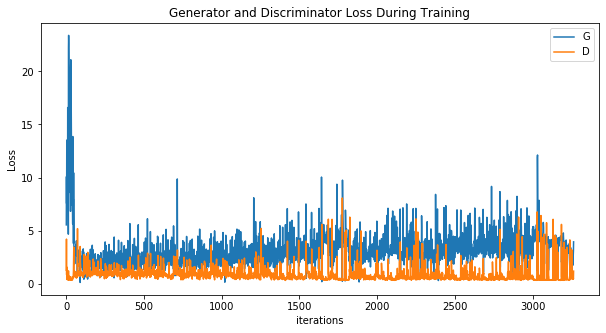

In [40]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

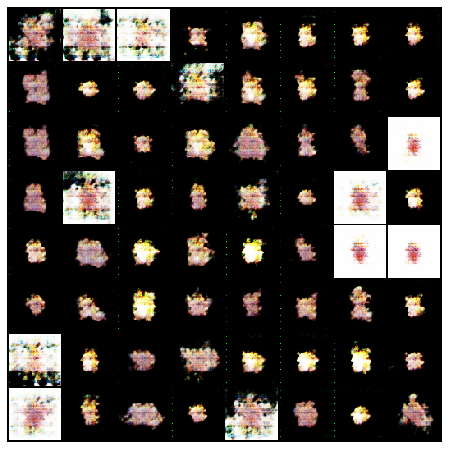

In [41]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_list]

Upon performing Training of the DCGAN model, it is obeserved that the model is able to generate pixalated Pokemon images quite similar to the input images.

Also, by tracking the loss values for both neural networks, it can be decided whether or not to re-train the model with more iterations to enhance image generation.

# Predicting DCGAN

In [54]:
output_dir = './data/Pokemon/prediction/'

In [55]:
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

In [56]:
# Loading the Generator State from the training phase
generator = Generator(ngpu).to(device)
checkpoint = torch.load('./data/Pokemon/checkpoints/Pokemon_checkpoint.pth.tar')
generator.load_state_dict(checkpoint['state_dict2'])
print("Generator Info:")
print(generator)

Generator Info:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
 

In [57]:
# Sample a batch from generator
sample_batch_z = torch.randn(batch_size, nz, 1, 1).to(device)

In [58]:
# Function for performing Image Prediction
def predict():
    # sample images from generator
    fake_batch_images = generator(sample_batch_z)
    vutils.save_image(fake_batch_images.detach(), "%s/sample_from_generator_with_seed_{%d}.png" %
                                   (output_dir, manualSeed), normalize=True)

In [59]:
# Function for plotting the predicted image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.figure(figsize=(10,5))
    plt.show()

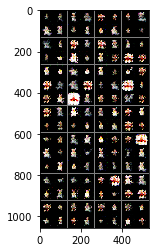

<Figure size 720x360 with 0 Axes>

Sampling Done! Image saved at ./data/Pokemon/prediction//sample_from_generator_with_seed_{876}.png


In [60]:
predict()
imshow(vutils.make_grid(generator(sample_batch_z).detach()))
print("Sampling Done! Image saved at %s/sample_from_generator_with_seed_{%d}.png" % ((output_dir, manualSeed)))

In [143]:
# Calculating the inception score for the predicted image
def calculate_inception_score(p_yx, eps=1E-16):
    # calculate p(y)
    p_y = expand_dims(p_yx.mean(axis=0), 0)
    # kl divergence for each image
    kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
    # sum over classes
    sum_kl_d = kl_d.sum(axis=1)
    # average over images
    avg_kl_d = mean(sum_kl_d)
    # undo the logs
    is_score = mpmath.exp(avg_kl_d)
    return is_score

In [144]:
# Conditional probabilities for high quality images
test_data = './data/Pokemon/prediction/sample_from_generator_with_seed_{876}.png'
inception = cv2.imread(test_data,cv2.IMREAD_UNCHANGED)
p_yx = asarray(inception)
score = calculate_inception_score(p_yx)
print(score)

5.73738794567782e+7032


##### Inception value = 109669.928566

Upon performing Image Prediction, it is stated that the model has been trained adequately to generate relatable pixalated images and predicting similar images to the the input data.

The results of Image Prediction are supported by the Inception Score value generated after evaluating the model. It proves that the model has predicted very well in comparison to other two experiments.

# Image Inpainting with DCGAN

In [13]:
# Image Conversion from .png to .jpg
num_iters = 2000
lamd = 0.1
save_dir = './data/Pokemon/inpainted_data'

im = Image.open("./data/Pokemon/output/val/images/blastoise.png")
rgb_im = im.convert('RGB')
rgb_im.save('./data/Pokemon/blastoise.jpg')

img = cv2.imread('./data/Pokemon/blastoise.jpg', cv2.IMREAD_UNCHANGED)
print('Original Dimensions : ',img.shape)
dim = (64, 64)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print('Resized Dimensions : ',resized.shape)
save = cv2.imwrite('./data/Pokemon/blastoise_resized.jpg',resized)

test_data = './data/Pokemon/blastoise_resized.jpg'

Original Dimensions :  (120, 120, 3)
Resized Dimensions :  (64, 64, 3)


In [14]:
# Loading Generator and Discriminator Networks
generator = Generator(ngpu)
discriminator = Discriminator(ngpu)

# Moving generator and disciminator to cuda device
generator.to(device)
discriminator.to(device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [15]:
# loading Generator and Discriminator network states
checkpoint = torch.load('./data/Pokemon/checkpoints/Pokemon_checkpoint.pth.tar')
print("load trained state dict from local files...")
generator.load_state_dict(checkpoint['state_dict2'])
discriminator.load_state_dict(checkpoint['state_dict1'])
print("generator and discriminator state dict loaded, done.")

print("Generator Info:")
print(generator)
print("Discriminator Info:")
print(discriminator)

load trained state dict from local files...
generator and discriminator state dict loaded, done.
Generator Info:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
 

In [16]:
image_shape = [nc, image_size, image_size]

criteria = nn.BCELoss()

In [17]:
# Function for performing Image Inpainting
def impainting():
    # Create output folder
    source_imagedir = os.path.join(save_dir, "source_images")
    masked_imagedir = os.path.join(save_dir, "masked_images")
    impainted_imagedir = os.path.join(save_dir, "impainted_images")
    os.makedirs(source_imagedir, exist_ok=True)
    os.makedirs(masked_imagedir,exist_ok=True)
    os.makedirs(impainted_imagedir,exist_ok=True)
    
    # How many pictures need to be repaired in total
    num_images = len(test_data)
    # How many batches can be divided into total for processing
    num_batches = int(np.ceil(num_images / batch_size))
    for idx in range(num_batches):
        # Perform the following processing for each batch image
        lidx = idx * batch_size
        hidx = min(num_images, (idx + 1) * batch_size)
        realBatchSize = hidx - lidx

        batch_images = [get_tensor_image(imgpath) for imgpath in glob.glob(test_data[lidx:hidx])]
        batch_images = torch.stack(batch_images).to(device)
        
        # The input original picture is ready, start to prepare the mask
        # Temporarily only provide center mask
        mask = torch.ones(size=image_shape).to(device)
        imageCenterScale = 0.3
        lm = int(image_size * imageCenterScale)
        hm = int(image_size * (1 - imageCenterScale))
        #Mask the center of the image to 0
        mask[:,lm:hm, lm:hm] = 0.0
        masked_batch_images = torch.mul(batch_images, mask).to(device)
        
        # First save the original picture and masked picture
        save_tensor_images(batch_images.detach(),
                   os.path.join(source_imagedir,"source_image_batch_{}.png".format(idx)))
    
        save_tensor_images(masked_batch_images.detach(), os.path.join(masked_imagedir, "masked_image_batch_{}.png".format(idx)))

       
        z_hat = torch.rand(size=[realBatchSize,nz,1,1],dtype=torch.float32,requires_grad=True,device=device)
        z_hat.data.mul_(2.0).sub_(1.0)
        opt = optim.Adam([z_hat],lr=learning_rate)       
        print("start impainting iteration for batch : {}".format(idx))
        v = torch.tensor(0,dtype=torch.float32,device=device)
        m = torch.tensor(0,dtype=torch.float32,device=device)
        
        for iteration in range(num_iters):
            # Iterate impainting for each batch image separately
            if z_hat.grad is not None:
                z_hat.grad.data.zero_()
            generator.zero_grad()
            discriminator.zero_grad()
            batch_images_g = generator(z_hat)
            batch_images_g_masked = torch.mul(batch_images_g,mask) 
            impainting_images = torch.mul(batch_images_g,(1-mask)) + masked_batch_images
            if iteration % 100==0:
                # Save impainting picture result
                print("\nsaving impainted images for batch: {} , iteration:{}".format(idx,iteration))
                save_tensor_images(impainting_images.detach(), os.path.join(impainted_imagedir,"impainted_image_batch_{}_iteration_{}.png".format(idx,iteration)))

            loss_context = torch.norm(
                (masked_batch_images-batch_images_g_masked),p=1)
            dis_output = discriminator(impainting_images)

            batch_labels = torch.full((realBatchSize,), 1, device=device)
            loss_perceptual = criteria(dis_output,batch_labels)
            
            total_loss = loss_context + lamd*loss_perceptual
            print("\r batch {} : iteration : {:4} , context_loss:{:.4f},perceptual_loss:{:4f}".format(idx,iteration,loss_context,loss_perceptual),end="")
            total_loss.backward()
            opt.step()

In [18]:
impainting()

start impainting iteration for batch : 0

saving impainted images for batch: 0 , iteration:0


..\aten\src\ATen\native\TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


 batch 0 : iteration :   99 , context_loss:80586.6094,perceptual_loss:4.255213
saving impainted images for batch: 0 , iteration:100
 batch 0 : iteration :  199 , context_loss:75747.8750,perceptual_loss:4.217930
saving impainted images for batch: 0 , iteration:200
 batch 0 : iteration :  299 , context_loss:72942.1875,perceptual_loss:4.217440
saving impainted images for batch: 0 , iteration:300
 batch 0 : iteration :  399 , context_loss:71048.1172,perceptual_loss:4.229118
saving impainted images for batch: 0 , iteration:400
 batch 0 : iteration :  499 , context_loss:69729.9844,perceptual_loss:4.236276
saving impainted images for batch: 0 , iteration:500
 batch 0 : iteration :  599 , context_loss:68582.5859,perceptual_loss:4.240395
saving impainted images for batch: 0 , iteration:600
 batch 0 : iteration :  699 , context_loss:67569.4062,perceptual_loss:4.246519
saving impainted images for batch: 0 , iteration:700
 batch 0 : iteration :  799 , context_loss:66734.4688,perceptual_loss:4.2464

Upon performing Image Inpainting application on the Pokemon Test Dataset, it can be clearly observed that the model fails in reconstructing images from masked images.

## Conlusion for Experiment 3:

Thus, this experiment validates that Training and Prediction Results are good, but the model fails to generate good Inpainting results due to dataset’s natural complexity.

Uncertainties are present in each modelling phase, but the images generated are better with the implementation of the Prediction model.

#### This research aims to work on this limitation thoroughly and implement a fully robust prediction and inpainting model in the future.

# Discussions:

Upon performing experiments on three datasets based on their nature of complexity, it is observed that images from the Celeb-A Faces dataset have been successfully predicted and inpainted with a good Inception Score than the other two datasets.

This has been achieved due to the presence of both Contextual and Perceptual Information within images.

Even though Flowers dataset and the Pokémon dataset lacked in producing Predicted images and Inpainted images respectively, all experiments were good enough in supporting Image Prediction.